
# Weather Data Analysis

The purpose of this notebook is to complete a data analysis task using publicly available weather observations from the **Frost API**, provided by the Norwegian Meteorological Institute.  
The Frost API gives access to measurements from a large number of weather stations across Norway, including stations such as Vigra, which we will make use of in the analysis. But there is also built in a search function that allows for the use of other weather stations.

The notebook will:
- Collect daily aggregated weather data (wind, precipitation, and temperature) from a chosen station.
- Process the data to calculate derived quantities such as weekly rainfall, hurricane-level wind events, and monthly temperature statistics.
- Present the results in graphical form to make long-term patterns easier to interpret.

By the end, we will have clear visualizations of:
- **Weekly rainfall** across the available dataset  
- **Number of hurricane-level wind events per year** (gusts > 32.6 m/s), treating consecutive storm days as a single event  
- **Monthly temperature trends** for a chosen month, with error bars to reflect variability  



In [39]:
# Imports for our functions
from frost_client import *
from data_handling import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

## Finding Weather Stations

Before collecting data we need to identify the weather station we want to use.  
The Frost API provides access to hundreds of connected stations across Norway. The function below allows us to **search for stations by name**.  

Any station with a matching name will be returned in a list, together with its metadata.  
Once we have identified the correct station, we can **copy its station ID** into the next cell (where marked) and use that ID when fetching the weather data.


In [45]:
search_term = input("Enter station name to search: ")

stations = search_station_by_name(search_term)
print(stations)

        id   name    lon      lat  masl municipality           county country
0  SN60990  VIGRA  6.115  62.5617    22        GISKE  MØRE OG ROMSDAL   Norge


## Collecting Data from the Frost API

Now that we have identified the correct station ID, we can collect the weather observations.  
By running the next code cell, a **HTTPS request** is sent to the Frost API with the chosen parameters (station ID, elements, and time span).  

The API responds with daily aggregated values for wind, precipitation, and temperature, which are then organized into a tidy pandas DataFrame.  
This dataset forms the basis for the analysis and visualizations that follow.


In [46]:
# Choose station, elements, time range
station = "SN60990"  # Change to desired station ID
elements = 'mean(wind_speed P1D), max(wind_speed_of_gust P1D), min(wind_speed P1D), max(wind_speed P1D), sum(precipitation_amount P1D), max(air_temperature P1D), min(air_temperature P1D), mean(air_temperature P1D)' # Possible to gather more data. URL for more info: https://frost.met.no/elementtable
span = "2013-01-01/2023-01-01" # Change to desired time span

df_long = fetch_data_observations(station, elements, span) # Fetch data in long format

# Convert to a wide format for easier reading
df_wide = pivot_table_elements(df_long)

## Visualizing the Weather Data

With the dataset prepared, we can now explore the results through plots.  
Each plot highlights a different aspect of the weather patterns:

1. **Hurricane-level wind events** per year — gusts greater than 32.6 m/s, with consecutive storm days counted as a single event.  
2. **Weekly rainfall totals** — showing how precipitation varies across the dataset.  
3. **Monthly temperature trends** — average daily mean temperature for a chosen month across years, with error bars to indicate variability.

The following code cells generate these plots in sequence.


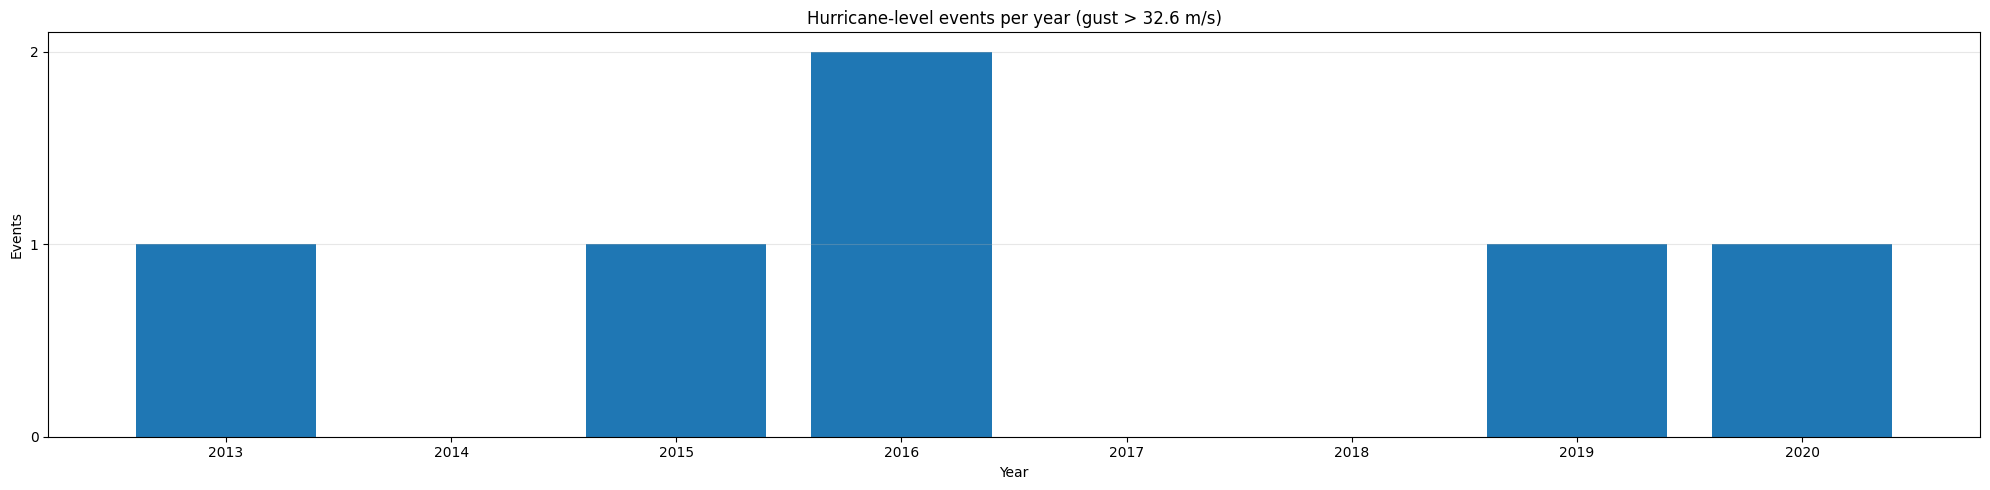

In [47]:
events = hurricane_events(df_wide, wind_col='max(wind_speed_of_gust P1D)')

plt.figure(figsize=(20, 5))
plt.bar(events["year"], events["events"])
plt.title(f"Hurricane-level events per year (gust > {HURRICANE_THRESHOLD} m/s)")
plt.xlabel("Year")
plt.ylabel("Events")

# Force y-axis to show integer ticks only
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

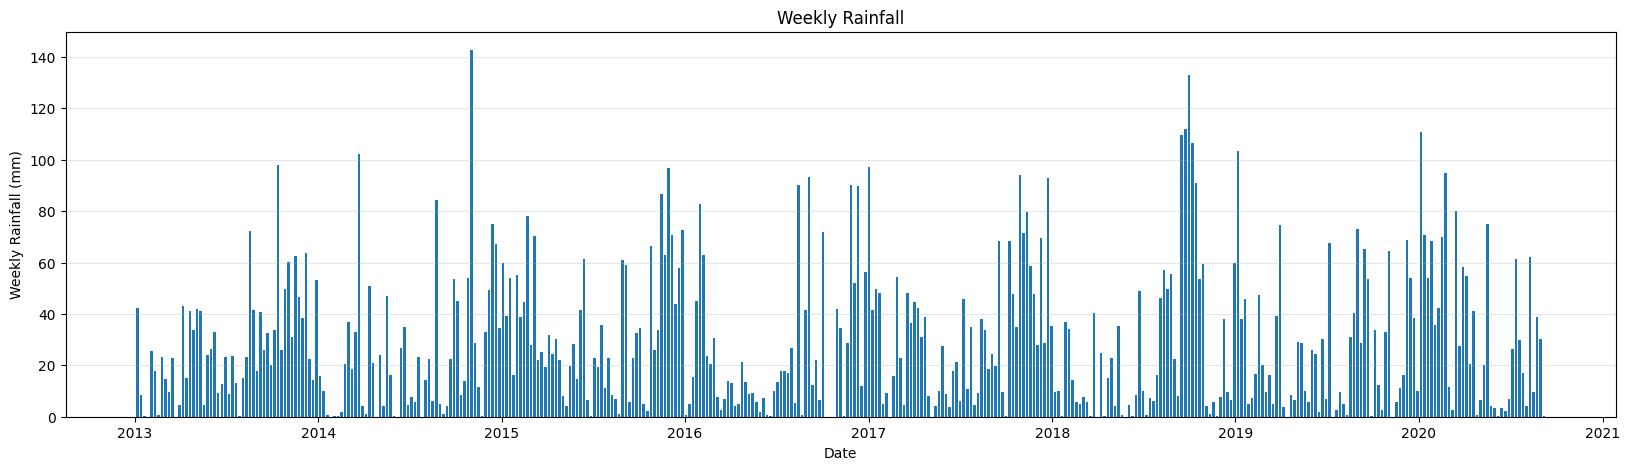

In [48]:
weekly = weekly_rainfall(df_wide, rain_col='sum(precipitation_amount P1D)')

plt.figure(figsize=(20,5))
plt.bar(weekly["time"], weekly["weekly_rain"], width=5, align="center")  
plt.title("Weekly Rainfall")
plt.xlabel("Date")
plt.ylabel("Weekly Rainfall (mm)")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

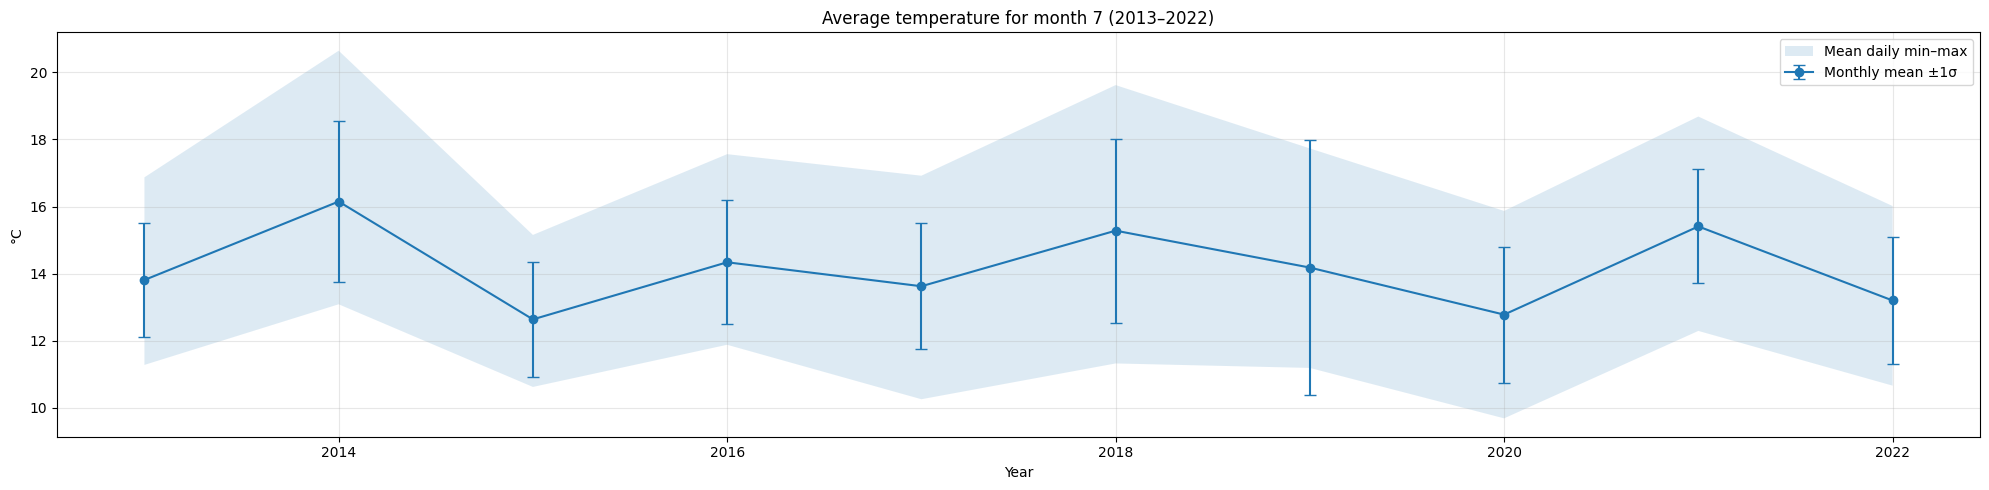

In [49]:
MONTH = 7 # July (1 = Jan, 2 = Feb, ..., 12 = Dec) Change to desired month
tstats = monthly_temperature_statistics(
    df_wide,
    target_month=MONTH,
    mean_temperature_column="mean(air_temperature P1D)",
    min_temperature_column="min(air_temperature P1D)",
    max_temperature_column="max(air_temperature P1D)",
    year_start=2013,
    year_end=2023,
)

plot_monthly_temp_with_band(tstats, month=MONTH)